In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
iris = pd.read_csv("iris_data.csv")

__LDA Functions__

In [299]:
class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

In [ ]:
###Priors are specified in the alphabetic order of the classes
###i.e. iris-setosa comes first, then versicolor then virginica
LDA_iris = LDA(iris, 'Class', priors = [.2,.3,.5])

In [ ]:
LDA_iris.priors

In [ ]:
LDA_iris.predict_probs(iris.loc[0:50,:])

In [ ]:
LDA_iris.predict_MAP()

In [ ]:
LDA_iris.misclass_rate()

In [ ]:
LDA_iris.misclass_xtabs()

In [ ]:
LDA_iris.misclass_pairplot()

__QDA Functions__

In [329]:
iris = pd.read_csv("iris_data.csv")
class QDA(LDA):
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 

In [330]:
QDA_iris =  QDA(iris, "Class", priors = [.98,.01,.01])

In [331]:
QDA_iris.predict_probs(iris)

,Iris-setosa,Iris-versicolor,Iris-virginica,True Class
0,1.000000e+00,5.090197e-28,3.085612e-43,Iris-setosa
1,1.000000e+00,7.400724e-21,1.267350e-36,Iris-setosa
2,1.000000e+00,1.633187e-23,3.556636e-38,Iris-setosa
3,1.000000e+00,8.451423e-21,8.697279e-34,Iris-setosa
4,1.000000e+00,3.659117e-29,2.185445e-43,Iris-setosa
...,...,...,...,...
145,4.143621e-153,3.168179e-09,1.000000e+00,Iris-virginica
146,2.347451e-126,1.657963e-04,9.998342e-01,Iris-virginica
147,1.963524e-135,1.067959e-03,9.989320e-01,Iris-virginica
148,1.358111e-156,1.171921e-06,9.999988e-01,Iris-virginica


In [290]:
QDA_iris.predict_MAP()

     Sepal Length  Sepal Width  Petal Length  Petal Width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]


,MAP Class,True Class
0,Iris-setosa,Iris-setosa
1,Iris-setosa,Iris-setosa
2,Iris-setosa,Iris-setosa
3,Iris-setosa,Iris-setosa
4,Iris-setosa,Iris-setosa
...,...,...
145,Iris-virginica,Iris-virginica
146,Iris-virginica,Iris-virginica
147,Iris-virginica,Iris-virginica
148,Iris-virginica,Iris-virginica


     Sepal Length  Sepal Width  Petal Length  Petal Width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]


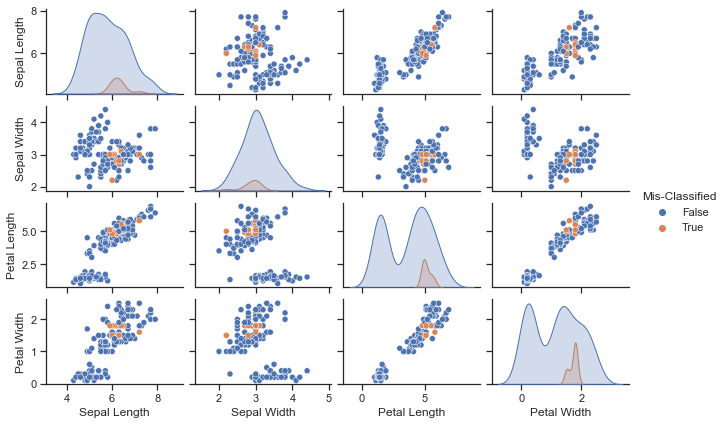

In [283]:
QDA_iris.misclass_pairplot()

In [284]:
QDA_iris.misclass_rate()

     Sepal Length  Sepal Width  Petal Length  Petal Width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]


0.06666666666666665

In [291]:
QDA_iris.misclass_xtabs()

     Sepal Length  Sepal Width  Petal Length  Petal Width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
..            ...          ...           ...          ...
145           6.7          3.0           5.2          2.3
146           6.3          2.5           5.0          1.9
147           6.5          3.0           5.2          2.0
148           6.2          3.4           5.4          2.3
149           5.9          3.0           5.1          1.8

[150 rows x 4 columns]


True Class,Iris-setosa,Iris-versicolor,Iris-virginica
MAP Class,,,
Iris-setosa,50,0,0
Iris-versicolor,0,48,1
Iris-virginica,0,2,49


In [ ]:
__Decision Boundaries__

In [ ]:
LDA_colors = round(LDA_MAP * 255)
iris['LDA_Hex'] = ['#%02x%02x%02x' % (int(row[0]), int(row[1]), int(row[2])) for ind, row in LDA_colors.iterrows()]
LDA_palette = {x:x for x in iris['LDA_Hex']}


In [ ]:
g = sns.pairplot(iris.drop('LDA_Misclass',axis = 1),hue="LDA_Hex", palette = LDA_palette, height = 1.5, aspect = 1.5, diag_kind = "none")
g._legend.remove()


In [ ]:
QDA_colors = round(QDA_MAP * 255)
iris['QDA_Hex'] = ['#%02x%02x%02x' % (int(row[0]), int(row[1]), int(row[2])) for ind, row in QDA_colors.iterrows()]
QDA_palette = {x:x for x in iris['QDA_Hex']}
g = sns.pairplot(iris.drop("QDA_Misclass", axis = 1),hue="QDA_Hex", palette = QDA_palette, height = 1.5, aspect = 1.5, diag_kind = "none")
g._legend.remove()
